# Compute $Q^{-1}$ of 4 meter rock specimen 

To analyze the effect of attenuation on the source time function pulse, we compute the frequency-dependent $Q^{-1}(\omega)$.

2024.07.17 Kurama Okubo

- 2024.07.22 update to count how many pairs we removed due to $|B|>1$.
- 2025.03.16 update for master plot

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import glob
from glob import glob
import numpy as np
import mpmath as mp
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from matplotlib import gridspec

from scipy import interpolate
from scipy.optimize import curve_fit  
import matplotlib as mpl
import pickle

import seaborn as sns 
from scipy.interpolate import CubicSpline


plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime  
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8

# Method to compute $Q^{-1}(\omega)$

$$ y(\omega) = s(\omega)G(\omega; \mathbf{x}) \exp{\left( - \dfrac{\omega t}{2 Q(\omega)} \right) }  $$

Thus, 

$$ \log \left| \dfrac{y(\omega)}{s(\omega)G(\omega; \mathbf{x})} \right| = - \dfrac{\omega t}{2 Q(\omega)}, $$

where $t$ is the travel time, and for P wave pulse we assume $t = r/v_p$, $r=|\mathbf{x}|$. The Green's function is numerically computed for the relative location from source to the receiver at $\mathbf{x}$.

Therefore,
$$  Q(\omega) = - \dfrac{\omega t}{2 \ln \left| \dfrac{y(\omega)}{s(\omega)G(\omega; \mathbf{x})} \right|} $$

$$  Q^{-1}(f) = - \dfrac{1}{\pi f t}  \ln \left| \dfrac{y(f)}{s(f)G(f; \mathbf{x})} \right| $$

We plot the right side for each balldrop-AE sensor pair, and stack them to obtain the averaged $Q^{-1}(\omega)$.

We denote $\dfrac{y(\omega)}{s(\omega)G(\omega; \mathbf{x})}  = B(\omega)$, which is computed in the previous notebook `08_plot_surfaceeffect_result_Case2.ipynb`.


## remove the negative $Q^{-1}(\omega)$ due to the noise of spectrum 
Due to the noise of spectra, sometimes $|B(\omega)|$ becomes greater than 1, which is not appropriate as the observation is amplified by $|B(\omega)|$. Therefore, we use the $Q^{-1}(\omega)$ only with $|B(\omega)|<1$ to obtain the stacked attenuation factor.

In [2]:
figdir = "../figure/09_Qinv/"
if not os.path.exists(figdir):
    os.makedirs(figdir)

# Compute the attenuation factor

In [3]:
# load B(omega)
with open('../data/Bomega_all.pickle', mode='rb') as fi:
    Bomega_all = pickle.load(fi)


In [4]:
Bomega_keys = list(Bomega_all)

In [5]:
Bomega_keys

datacases=[]
for key in Bomega_all:
    if ("BD" in key) & (key[:13] not in datacases):
        datacases.append(key[:13])

In [6]:
Ncases = len(datacases)
print(f"Ncases: {Ncases}")
vp = 6200 #[m/s]

NFFT = Bomega_all["NFFT"]
dt = Bomega_all["dt"]
freq = np.fft.rfftfreq(NFFT, dt)

Qinv_all = np.zeros((Ncases, len(freq)-1), float) # we avoid f=0

Ncases: 117


In [7]:
np.log(np.e)

1.0

In [8]:
VR_threshold = 0.95
const_Bover1 = np.nan #0.96 #np.nan #0.99 #np.nan # skip the value when B(omega)>1

count_pairs_VRthresh = 0
dist_pairs_VRthresh = []

for i, dataindex in enumerate(datacases):
    # i = 0
    # dataindex = datacases[i]

    dist = Bomega_all[f"{dataindex}_dist"]
    VR = Bomega_all[f"{dataindex}_VR"]
    if VR<VR_threshold:
        continue
    else:
        count_pairs_VRthresh += 1
        dist_pairs_VRthresh.append(dist)

    tt = dist*1e-3/vp # [s]
#     print(tt*1e6)

    Battenu = Bomega_all[f"{dataindex}_Battenu"]
    Battenu_smoothed = Bomega_all[f"{dataindex}_Battenu_smoothed"]
    
    # remove the inconsistent data with B(omega)
    
    # compute to align a given resp
    # const_Bover1_byQ = np.exp(5e-3 * -np.pi * 2e5 * tt)
    
    # Battenu[np.abs(Battenu)>1] = const_Bover1 # const_Bover1_byQ  #const_Bover1
    Battenu_smoothed[np.abs(Battenu_smoothed)>1] =  const_Bover1 #const_Bover1_byQ # const_Bover1
    
#     Qinv_all[i, :] = -(1/(np.pi*freq[1:]*tt)) * np.log(np.abs(Battenu[1:]))
    Qinv_all[i, :] = -(1/(np.pi *freq[1:]*tt)) * np.log(np.abs(Battenu_smoothed[1:]))
#     print(np.sign(np.log(np.abs(Battenu[1:]))))

In [9]:
print(f"Number of pairs: {count_pairs_VRthresh}/{len(datacases)}")

print(f"Distance of pairs: {np.mean(dist_pairs_VRthresh)} ± {np.std(dist_pairs_VRthresh)}mm")


Number of pairs: 67/117
Distance of pairs: 138.37737249799287 ± 45.44409166348148mm


In [10]:
Battenu_smoothed

array([ 9.72848267e-01-2.27680054e-04j,  9.97091068e-01+7.88146137e-03j,
                   nan+0.00000000e+00j,             nan+0.00000000e+00j,
                   nan+0.00000000e+00j,  9.65593112e-01+7.15588065e-02j,
        9.29669676e-01+8.24876617e-02j,  8.93662102e-01+8.78174852e-02j,
        8.51866520e-01+8.46046260e-02j,  8.01307515e-01+7.50228325e-02j,
        7.42578916e-01+5.77987345e-02j,  6.70283462e-01+3.14101451e-02j,
        5.81130962e-01+6.33008690e-03j,  4.81891480e-01-1.07606238e-02j,
        3.73093244e-01-1.68028677e-02j,  2.65234017e-01-4.59859279e-05j,
        1.84388341e-01+3.15103091e-02j,  1.30442313e-01+5.39782563e-02j,
        8.48831246e-02+6.83623675e-02j,  4.55940662e-02+8.34940122e-02j,
        1.12576336e-02+9.22135318e-02j, -2.23934558e-02+9.28562990e-02j,
       -4.38389049e-02+8.58759118e-02j, -4.68086799e-02+6.63926978e-02j,
       -3.84945047e-02+4.83012524e-02j, -2.19691675e-02+5.32880774e-02j,
       -7.42313750e-03+8.68591702e-02j, -1.14946855

In [11]:
# count the non-nan values
print(Qinv_all.shape)
np.count_nonzero(~np.isnan(Qinv_all), axis=0)


(117, 128)


array([ 77,  82,  79,  85,  93, 100, 113, 115, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 116, 115, 114, 113, 111, 109, 107, 105, 103, 100,
        96,  97,  95,  93,  89,  84,  83,  85,  86,  89,  91,  95, 101,
       112, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 116, 116, 115, 114, 111, 109, 109, 108, 108, 106,
       105, 102, 106, 101, 105, 101, 101, 101,  97, 101,  98,  97,  97,
        95,  97,  95,  94,  94,  94,  93,  93,  93,  97, 103])

Text(0, 0.5, 'Attenuation, Q$^{-1}$')

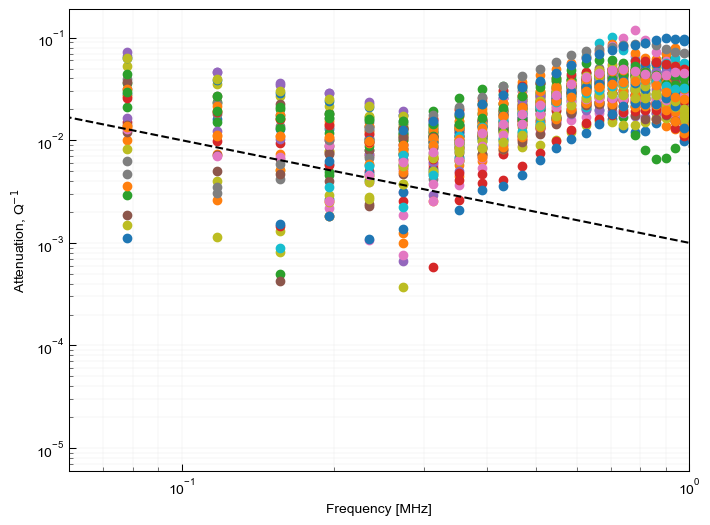

In [12]:
# plot figure for debugging
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i, dataindex in enumerate(datacases):
    
    dist = Bomega_all[f"{dataindex}_dist"]
#     if dist > 90:
#         continue
    
    ax.loglog(freq[1:]*1e-6, Qinv_all[i, :], "o",)# c="gray", ms=3) # low VR cases are not plotted in log
#     ax.plot(freq[1:]*1e-6, Qinv_all[i, :], "o",)# c="gray", ms=3)
    
# plot P waveform
ax.set_xlim([0.06,1.])
# ax.set_ylim([1e-4, 1])
# ax.set_ylim([-0.1, 0.1])

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="both",)

# plot constant B slope f^{-1}

constB_k = 1e3
constB = constB_k*freq[1:]**(-1)
ax.plot(freq[1:]*1e-6, constB, "k--")

# ax.legend(loc=0)

ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Attenuation, Q$^{-1}$")

# Compute stacked $Q^{-1}$

We compute the statistics of the data to obtain the quartile of $Q^{-1}$ and get the median curve, which is used to compute the attenuation factor.

In [13]:
# Store the data to dataframe
# df_Qinv = pd.DataFrame(data=Qinv_all, index=datacases, columns=freq[1:])

df_Qinv = pd.DataFrame(columns=["dataindex", "freq", "Qinv", "distance[mm]"])

for i, dataindex in enumerate(datacases):
    # i = 0
    # dataindex = datacases[i]

    dist = Bomega_all[f"{dataindex}_dist"]
    VR = Bomega_all[f"{dataindex}_VR"]
    
    if VR<VR_threshold:
        continue
        
    tt = dist*1e-3/vp # [s]
    #     print(tt*1e6)

    Battenu = Bomega_all[f"{dataindex}_Battenu"]
    Battenu_smoothed = Bomega_all[f"{dataindex}_Battenu_smoothed"]

    # remove the inconsistent data with B(omega)<1
    Battenu[np.abs(Battenu)>1] = const_Bover1
    Battenu_smoothed[np.abs(Battenu_smoothed)>1] = const_Bover1

    #     Qinv_all[i, :] = -(1/(np.pi*freq[1:]*tt)) * np.log(np.abs(Battenu[1:]))
    Qinv_tmp= -(1/(np.pi*freq[1:]*tt)) * np.log(np.abs(Battenu_smoothed[1:]))
    #     print(np.sign(np.log(np.abs(Battenu[1:]))))

    data = {"freq":freq[1:]/1e6, "Qinv":Qinv_tmp}

    df_tmp = pd.DataFrame.from_dict(data)
    df_tmp.loc[:, "dataindex"] = dataindex
    df_tmp.loc[:, "distance[mm]"] = dist
    df_tmp.loc[:, "VR"] = VR

    if not df_Qinv.empty:
        df_Qinv = pd.concat([df_Qinv, df_tmp], ignore_index=True)
    else:
        df_Qinv = df_tmp

In [14]:
Npair_valid_all = np.zeros((len(freq[1:]), 2)) # count the number where |B(ω)| <= 1
for i, f in enumerate(freq[1:]/1e6):
    df_tmp = df_Qinv[df_Qinv["freq"]==f]
    Nnan = df_tmp["Qinv"].isna().sum()
    Npair_valid = count_pairs_VRthresh-Nnan
    Npair_valid_all[i, :] = [f, Npair_valid]
#     print(f, Nnan, )

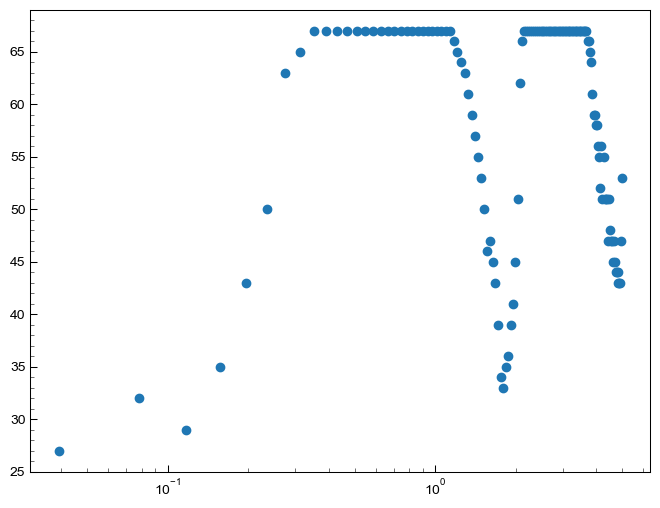

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.bar(x[:-1], y, width=np.diff(x), log=True,ec="k", align="edge")
ax.plot(Npair_valid_all[:, 0], Npair_valid_all[:, 1], "o")
ax.set_xscale('log')

In [16]:
print(f"Maximum removal at {Npair_valid_all[2, 0]}MHz is {count_pairs_VRthresh -  Npair_valid_all[2, 1]}")

Maximum removal at 0.1171875MHz is 38.0


In [17]:
# Npair_valid_all

In [18]:
Npair_valid_all.shape

(128, 2)

In [19]:
# Number of nan due to B(omega)>1
np.sum(np.isnan(df_Qinv["Qinv"]))

1118

In [20]:
len(df_Qinv)/128

67.0

In [21]:
freq

array([      0. ,   39062.5,   78125. ,  117187.5,  156250. ,  195312.5,
        234375. ,  273437.5,  312500. ,  351562.5,  390625. ,  429687.5,
        468750. ,  507812.5,  546875. ,  585937.5,  625000. ,  664062.5,
        703125. ,  742187.5,  781250. ,  820312.5,  859375. ,  898437.5,
        937500. ,  976562.5, 1015625. , 1054687.5, 1093750. , 1132812.5,
       1171875. , 1210937.5, 1250000. , 1289062.5, 1328125. , 1367187.5,
       1406250. , 1445312.5, 1484375. , 1523437.5, 1562500. , 1601562.5,
       1640625. , 1679687.5, 1718750. , 1757812.5, 1796875. , 1835937.5,
       1875000. , 1914062.5, 1953125. , 1992187.5, 2031250. , 2070312.5,
       2109375. , 2148437.5, 2187500. , 2226562.5, 2265625. , 2304687.5,
       2343750. , 2382812.5, 2421875. , 2460937.5, 2500000. , 2539062.5,
       2578125. , 2617187.5, 2656250. , 2695312.5, 2734375. , 2773437.5,
       2812500. , 2851562.5, 2890625. , 2929687.5, 2968750. , 3007812.5,
       3046875. , 3085937.5, 3125000. , 3164062.5, 

In [22]:
df_Qinv

,freq,Qinv,dataindex,distance[mm],VR
0,0.039062,0.023767,OL01__BD_0220,93.621579,0.970212
1,0.078125,0.028199,OL01__BD_0220,93.621579,0.970212
2,0.117188,0.016207,OL01__BD_0220,93.621579,0.970212
3,0.156250,0.013001,OL01__BD_0220,93.621579,0.970212
4,0.195312,0.012824,OL01__BD_0220,93.621579,0.970212
...,...,...,...,...,...
8571,4.843750,0.014602,OL32__BD_3940,127.816274,0.983534
8572,4.882812,0.017098,OL32__BD_3940,127.816274,0.983534
8573,4.921875,0.011692,OL32__BD_3940,127.816274,0.983534
8574,4.960938,0.013181,OL32__BD_3940,127.816274,0.983534


In [23]:
df_Qinv.Qinv.min()

9.527644373202527e-06

In [24]:
df_Qinv["distance[mm]"].max()

233.73703172582643

In [25]:
# compute quartiles of Qinv

# .quantile([0.25, 0.5, 0.75])
qinv_25 = np.zeros(len(freq[1:]))
qinv_50 = np.zeros(len(freq[1:]))
qinv_75 = np.zeros(len(freq[1:]))

for i, f in enumerate(freq[1:]):
    [qinv_25[i], qinv_50[i], qinv_75[i]] = df_Qinv[df_Qinv["freq"] == f/1e6]["Qinv"].quantile([0.25, 0.5, 0.75])

In [26]:
data = {"freq": freq[1:]/1e6, "Qinv_25": qinv_25, "Qinv_50": qinv_50, "Qinv_75": qinv_75}
df_Qinv_quantile = pd.DataFrame.from_dict(data)
df_Qinv_quantile

,freq,Qinv_25,Qinv_50,Qinv_75
0,0.039062,0.013403,0.036839,0.048583
1,0.078125,0.009528,0.018667,0.036067
2,0.117188,0.007164,0.016207,0.023822
3,0.156250,0.004907,0.010891,0.017656
4,0.195312,0.004253,0.008820,0.014757
...,...,...,...,...
123,4.843750,0.011139,0.021959,0.028942
124,4.882812,0.010264,0.018032,0.026456
125,4.921875,0.008013,0.015396,0.025749
126,4.960938,0.006742,0.010997,0.021952


In [27]:
df_Qinv[df_Qinv["freq"] == f/1e6]["Qinv"]

127     0.008813
255     0.000744
383     0.025428
511          NaN
639     0.023703
          ...   
8063         NaN
8191    0.024499
8319    0.002324
8447    0.001933
8575    0.003557
Name: Qinv, Length: 67, dtype: float64

In [28]:
df_Qinv["freq"] - f

0      -5.000000e+06
1      -5.000000e+06
2      -5.000000e+06
3      -5.000000e+06
4      -5.000000e+06
            ...     
8571   -4.999995e+06
8572   -4.999995e+06
8573   -4.999995e+06
8574   -4.999995e+06
8575   -4.999995e+06
Name: freq, Length: 8576, dtype: float64

In [29]:
df_Qinv["freq"] - f

0      -5.000000e+06
1      -5.000000e+06
2      -5.000000e+06
3      -5.000000e+06
4      -5.000000e+06
            ...     
8571   -4.999995e+06
8572   -4.999995e+06
8573   -4.999995e+06
8574   -4.999995e+06
8575   -4.999995e+06
Name: freq, Length: 8576, dtype: float64

In [30]:
lc = sns.color_palette("colorblind")
lc

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

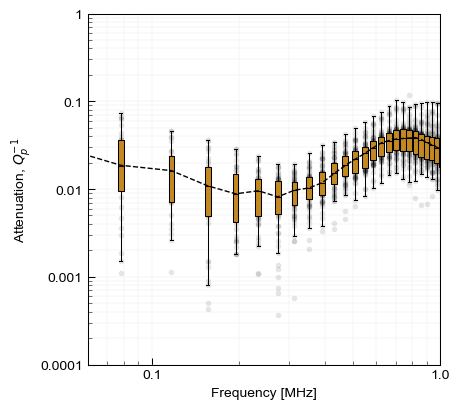

In [31]:
np.random.seed(20240718)
fig, ax = plt.subplots(1, 1, figsize=(4.7, 4.2))

# ax.grid(True)
# ax.set_axisbelow(True)

js = 4

sns.stripplot(x="freq", y="Qinv", data=df_Qinv, jitter=False, native_scale=True, log_scale=True, color="k", size=js,
              zorder=1, legend=None, ax=ax, alpha=0.1)

sns.boxplot(x="freq", y="Qinv", data=df_Qinv, showfliers=False,  ax=ax, log_scale=True, native_scale=True, width=6, 
            zorder=2, linewidth=.75, linecolor="k", fill=True, color=lc[1])


# ax.plot(df_Qinv_quantile.freq, df_Qinv_quantile.Qinv_25, "-", c="b", lw=0.75)
ax.plot(df_Qinv_quantile.freq, df_Qinv_quantile.Qinv_50, "k--", lw=1.0, zorder=4)
# ax.plot(df_Qinv_quantile.freq, df_Qinv_quantile.Qinv_75, "-", c="r", lw=0.75)

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1.0))

ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Attenuation, $Q_p^{-1}$")

# ax.set_xscale('log')
# ax.set_yscale('log')

# reference curve of f^{-1}
constB_k = 7e3
constB = constB_k*freq[1:]**(-1)
# ax.plot(freq[1:]*1e-6, constB, "k--")

ax.set_xlim([0.06,1.])
# ax.set_xlim([1e-3 ,1.])
ax.set_ylim([1e-4, 1])

ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1g'))


ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="both",)
ax.set_axisbelow(True)
plt.tight_layout()

plt.savefig(figdir+"/Qinv_stats.png", format="png", dpi=70, bbox_inches="tight")
plt.savefig(figdir+"/Qinv_stats.pdf", format="pdf", bbox_inches="tight") # keep transparency


In [32]:
df_Qinv_quantile.to_csv("../data/df_Qinv_quantile.csv")

## Search min and max Q

In [33]:
# bounds the frequency range to evaluate the min and max Q
inds_freqrange = np.where((0.1 < df_Qinv_quantile["freq"]) & (df_Qinv_quantile["freq"] < 1.0))[0]

In [34]:
Qinv_argmax = df_Qinv_quantile["Qinv_50"][inds_freqrange].idxmax()
Q_min = 1/df_Qinv_quantile["Qinv_50"][inds_freqrange].max() # inverse of Qinv
Q_min_freq = df_Qinv_quantile["freq"].loc[Qinv_argmax]

Qinv_argmin = df_Qinv_quantile["Qinv_50"][inds_freqrange].idxmin()
Q_max = 1/df_Qinv_quantile["Qinv_50"][inds_freqrange].min()
Q_max_freq = df_Qinv_quantile["freq"].loc[Qinv_argmin]


Qmin: 25.94 at 820.3125 kHz
Qmax: 122.73 at 273.4375 kHz


(0.06, 1.0)

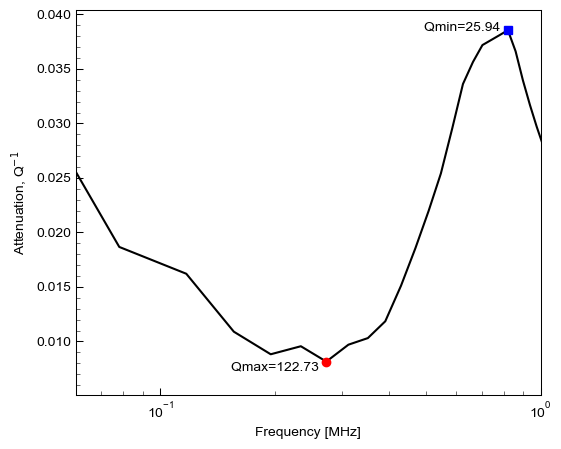

In [35]:
# Plot min and max Q
fig, ax = plt.subplots(1, 1, figsize=(6., 5))

ax.semilogx(df_Qinv_quantile["freq"], df_Qinv_quantile["Qinv_50"], "k-")

ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Attenuation, Q$^{-1}$")

ax.plot(Q_min_freq, 1/Q_min, "bs")
ax.plot(Q_max_freq, 1/Q_max, "ro")
ax.text(Q_min_freq, 1/Q_min, f"Qmin={Q_min:.2f}  ", ha="right")
ax.text(Q_max_freq, 1/Q_max, f"Qmax={Q_max:.2f}  ", ha="right", va="top")
print(f"Qmin: {Q_min:.2f} at {Q_min_freq*1e3} kHz")
print(f"Qmax: {Q_max:.2f} at {Q_max_freq*1e3} kHz")
# ax.set_xscale('log')
# ax.set_yscale('log')

# reference curve of f^{-1}
constB_k = 7e3
constB = constB_k*freq[1:]**(-1)
# ax.plot(freq[1:]*1e-6, constB, "k--")

ax.set_xlim([0.06,1.])
# ax.set_xlim([1e-3 ,1.])
# ax.set_ylim([1e-4, 1])




## Compute $B(\omega)$

we compute $ \exp \left( {-\dfrac{\pi f t}{Q(f)}} \right) $ as the attenuation factor.

In [36]:
Bf = np.zeros((len(freq[1:]), 3))
dist_gouge = 185.1e-3 # gouge event distance
tt = dist_gouge/vp

for i, f in enumerate(freq[1:]):
    
    Bf[i, 0] = np.exp(-np.pi*f*tt*df_Qinv_quantile[df_Qinv_quantile["freq"]==f/1e6].Qinv_25.values[0])
    Bf[i, 1] = np.exp(-np.pi*f*tt*df_Qinv_quantile[df_Qinv_quantile["freq"]==f/1e6].Qinv_50.values[0])
    Bf[i, 2] = np.exp(-np.pi*f*tt*df_Qinv_quantile[df_Qinv_quantile["freq"]==f/1e6].Qinv_75.values[0])

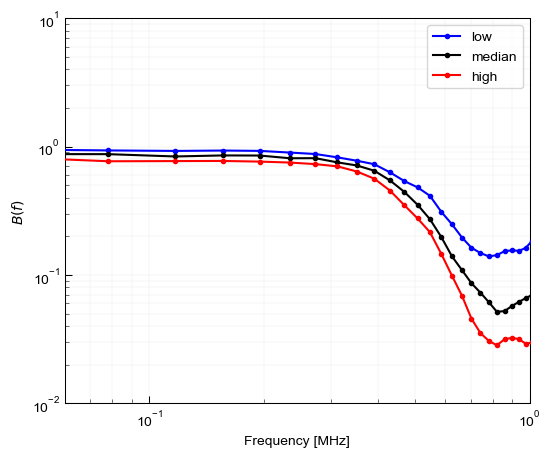

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6., 5))

ax.loglog(df_Qinv_quantile.freq,Bf[:,0], "b.-", zorder=4, label="low")
ax.loglog(df_Qinv_quantile.freq,Bf[:,1], "k.-", zorder=4, label="median")
ax.loglog(df_Qinv_quantile.freq,Bf[:,2], "r.-", zorder=4, label="high")

ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("$B(f)$")

# ax.set_xscale('log')
# ax.set_yscale('log')

# reference curve of f^{-1}
constB_k = 7e3
constB = constB_k*freq[1:]**(-1)
# ax.plot(freq[1:]*1e-6, constB, "k--")


ax.set_xlim([0.06,1.])
# ax.set_xlim([1e-3 ,1.])
ax.set_ylim([1e-2, 1e1])
ax.legend(loc=0)
# ax.set_ylim([-0.1, 0.1])

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="both",)


In [38]:
20*np.log10(np.abs(Bf[:,0]))

array([ -0.42653661,  -0.6064377 ,  -0.68389866,  -0.62464094,
        -0.6766818 ,  -0.93268614,  -1.16383224,  -1.68698313,
        -2.2131224 ,  -2.75635736,  -4.03100869,  -5.39038018,
        -6.37143882,  -7.677717  , -10.17976843, -12.12238694,
       -14.18242541, -15.77631329, -16.59294063, -17.12629185,
       -16.92245845, -16.29756678, -16.18087185, -16.25436345,
       -15.79436958, -14.67370445, -13.35443652, -10.13752738,
       -10.93381878, -12.27756202, -11.84323847, -10.86706949,
        -9.46768729,  -9.82921469, -11.18141613, -11.16965767,
       -10.31372604,  -7.18791041,  -6.38801369,  -8.06178547,
        -4.4630911 ,  -3.62683187,  -6.05803129,  -6.13577515,
        -8.52452044,  -9.7059614 ,  -8.91350255,  -9.23498582,
        -6.71498453, -10.51683301, -11.34556175, -10.43695166,
       -10.07743207, -15.42109756, -19.09491694, -21.94551327,
       -27.38139289, -27.289803  , -32.48714252, -34.16174603,
       -40.33289922, -37.03700944, -45.0930582 , -42.96

# compute the cut-off level (-3dB)

In [39]:
flatlevel_inds = np.where( (0.2 < freq[1:]/1e6) & (freq[1:]/1e6 < 0.3) )
cutoff_dB = np.zeros((3, 2))

freq_q = np.logspace(-1, 0, 201)

for i in range(3):
    Bf_tr_dB = 20*np.log10(np.abs(Bf[:,i]))
    flatlevel = np.mean(Bf_tr_dB[flatlevel_inds])
    print(flatlevel)
    cutoff_level = flatlevel - 3.0
    
    # interpolate the B(omega)
    Bf_tr_interp = np.interp(freq_q, df_Qinv_quantile.freq, Bf_tr_dB)
    
    cutoff_ind = np.where(Bf_tr_interp < cutoff_level)[0][0]
    cutoff_dB[i, :] = [freq_q[cutoff_ind], Bf_tr_interp[cutoff_ind]]
    

-1.04825919183302
-1.8198289170279018
-2.6171108864196055


In [40]:
cutoff_dB

array([[ 0.43151908, -4.0947474 ],
       [ 0.4216965 , -4.97922767],
       [ 0.40738028, -5.81043253]])

In [41]:
df_Qinv_quantile.freq

0      0.039062
1      0.078125
2      0.117188
3      0.156250
4      0.195312
         ...   
123    4.843750
124    4.882812
125    4.921875
126    4.960938
127    5.000000
Name: freq, Length: 128, dtype: float64

In [42]:
cutoff_dB

array([[ 0.43151908, -4.0947474 ],
       [ 0.4216965 , -4.97922767],
       [ 0.40738028, -5.81043253]])

In [43]:
np.where(Bf_tr_dB < cutoff_level)[0][0]

10

<>:13: SyntaxWarning: invalid escape sequence '\o'
<>:13: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6n/nsqc1sbn1kn5ccc7y51plgz00000gn/T/ipykernel_14547/3840556968.py:13: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel("$|B(\omega)| [dB]$")


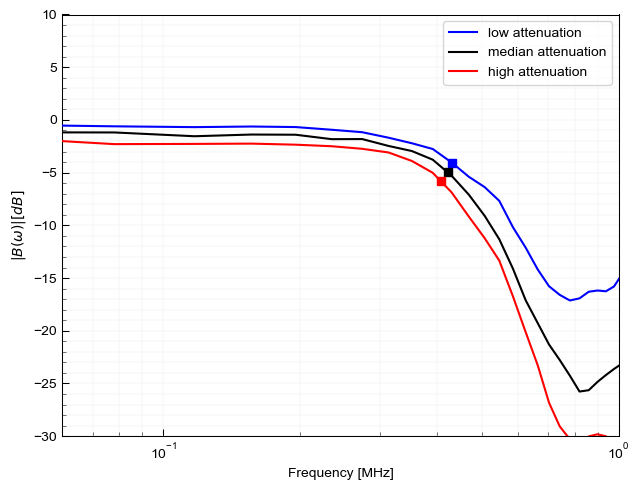

In [58]:
# plot in dB
fig, ax = plt.subplots(1, 1, figsize=(6.5, 5))

ax.semilogx(df_Qinv_quantile.freq, 20*np.log10(np.abs(Bf[:,0])), "b-", zorder=4, label="low attenuation")
ax.semilogx(df_Qinv_quantile.freq, 20*np.log10(np.abs(Bf[:,1])), "k-", zorder=4, label="median attenuation")
ax.semilogx(df_Qinv_quantile.freq, 20*np.log10(np.abs(Bf[:,2])), "r-", zorder=4, label="high attenuation")

ax.semilogx(cutoff_dB[0, 0], cutoff_dB[0, 1], "bs")
ax.semilogx(cutoff_dB[1, 0], cutoff_dB[1, 1], "ks")
ax.semilogx(cutoff_dB[2, 0], cutoff_dB[2, 1], "rs")

ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("$|B(\omega)| [dB]$")

# ax.set_xscale('log')
# ax.set_yscale('log')

# reference curve of f^{-1}
constB_k = 7e3
constB = constB_k*freq[1:]**(-1)
# ax.plot(freq[1:]*1e-6, constB, "k--")


ax.set_xlim([0.06,1.])
# ax.set_xlim([1e-3 ,1.])
ax.set_ylim([-30, 10])
ax.legend(loc=0)
# ax.set_ylim([-0.1, 0.1])

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="both",)

plt.tight_layout()

plt.savefig(figdir+"/Bomega_dB.png", format="png", dpi=70, bbox_inches="tight")
# plt.savefig(figdir+"/Bomega_dB.pdf", format="eps", bbox_inches="tight")


In [45]:
cutoff_dB

array([[ 0.43151908, -4.0947474 ],
       [ 0.4216965 , -4.97922767],
       [ 0.40738028, -5.81043253]])

### Impulse response with the $Q^{-1}$ model

In [46]:
def get_Qinv(freq, fq, Qinv):
    # interpolate the Q from the Qinv data
    cs = CubicSpline(fq, Qinv)
    
    Qinv_interp = np.zeros(len(freq))
    for i, ff in enumerate(freq):
        if ff<fq[0]:
            Qinv_interp[i] = Qinv[0] # extrapolate the minimum frequency Qinv
        elif ff>fq[-1]:
            Qinv_interp[i] = Qinv[-1] # extrapolate the maximum frequency Qinv
        else:
            Qinv_interp[i] = cs(ff)  
                
    return Qinv_interp

In [47]:
Npos = 301 
fmin = 0#df_Qinv_quantile.freq.values[0]*1e6
fmax = 20e6 #df_Qinv_quantile.freq.values[-1]*1e6
freqsyn = np.linspace(0, fmax, Npos)
delta_f_syn = freqsyn[1]-freqsyn[0]
delta_f_syn


66666.66666666667

In [48]:
Qinvsyn_25 = get_Qinv(freqsyn, df_Qinv_quantile.freq.values*1e6, df_Qinv_quantile["Qinv_25"].values)
Qinvsyn_50 = get_Qinv(freqsyn, df_Qinv_quantile.freq.values*1e6, df_Qinv_quantile["Qinv_50"].values)
Qinvsyn_75 = get_Qinv(freqsyn, df_Qinv_quantile.freq.values*1e6, df_Qinv_quantile["Qinv_75"].values)

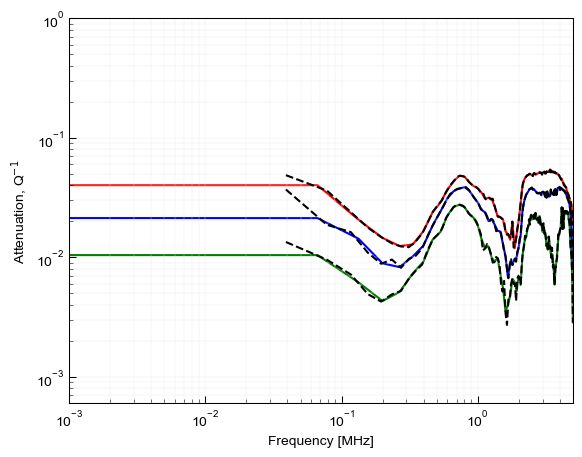

In [49]:
# check the interpolation
fig, ax = plt.subplots(1, 1, figsize=(6.5, 5))


ax.plot(df_Qinv_quantile.freq, df_Qinv_quantile.Qinv_25, "k--", zorder=2)
ax.plot(df_Qinv_quantile.freq, df_Qinv_quantile.Qinv_50, "k--", zorder=2)
ax.plot(df_Qinv_quantile.freq, df_Qinv_quantile.Qinv_75, "k--", zorder=2)

ax.plot(freqsyn/1e6, Qinvsyn_25, "g-", zorder=1)
ax.plot(freqsyn/1e6, Qinvsyn_50, "b-", zorder=1)
ax.plot(freqsyn/1e6, Qinvsyn_75, "r-", zorder=1)


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Attenuation, Q$^{-1}$")

# ax.set_xscale('log')
# ax.set_yscale('log')

# reference curve of f^{-1}
constB_k = 7e3
constB = constB_k*freq[1:]**(-1)
# ax.plot(freq[1:]*1e-6, constB, "k--")


ax.set_xlim([1e-3,5.])
# ax.set_xlim([1e-3 ,1.])
ax.set_ylim([6e-4, 1])

# ax.set_ylim([-0.1, 0.1])

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="both",)


In [50]:
# compute attenuation factor
Bfsyn = np.zeros((len(freqsyn), 3))
dist_gouge = 185.1e-3 # gouge event distance
tt = dist_gouge/vp

for i, ff in enumerate(freqsyn):
    
    Bfsyn[i, 0] = np.exp(-np.pi*ff*tt*Qinvsyn_25[i])
    Bfsyn[i, 1] = np.exp(-np.pi*ff*tt*Qinvsyn_50[i])
    Bfsyn[i, 2] = np.exp(-np.pi*ff*tt*Qinvsyn_75[i])


In [51]:
# Nrfft = 2*10

y_25 = np.fft.irfft(Bfsyn[:,0])
y_50 = np.fft.irfft(Bfsyn[:,1])
y_75 = np.fft.irfft(Bfsyn[:,2])


Ntrace = 2*(Npos-1)
assert len(y_25) == Ntrace

dt = 1/(Ntrace*delta_f_syn)
tvec = np.arange(0, Ntrace, step=1)*dt

# nyquist is 5MHz.

In [52]:
dt

2.5e-08

Text(0.5, 0, 'Time [μs]')

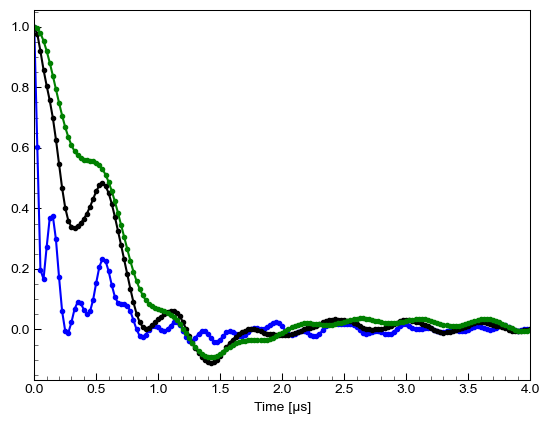

In [53]:
plt.plot(tvec*1e6, y_25/np.max(y_25), ".b-")
plt.plot(tvec*1e6, y_50/np.max(y_50), ".k-")
plt.plot(tvec*1e6, y_75/np.max(y_75), ".g-")

# plt.plot(tvec*1e6, y_25[::-1], "xb")
# plt.plot(tvec*1e6, y_50[::-1], "xk")
# plt.plot(tvec*1e6, y_75[::-1], "xg")

plt.xlim(0, 4)
plt.xlabel("Time [μs]")

The figure above is the impulse response of the Qmodel. We further analyze this with the Futterman function.


In [54]:
Qp = 50
tt_lab = 200e-3/6200
tt_lin2016 = 14e3/5000
tstar_lab = tt_lab/Qp
tstar_lin2016 = tt_lin2016/Qp

In [55]:
tstar_lab

6.451612903225807e-07

In [56]:
tstar_lin2016

0.055999999999999994

In [57]:
tstar_lab/tstar_lin2016 # this indicates the scaling of Futterman function pulse width

1.1520737327188942e-05

The pulse width of Fig. 10b is ~0.2s. $0.2*1e-5$ = 2μs, which is comparable to the figure above. Thus, the scaling is reasonable.